### Run continuous scan for each KS unit; only pursue template-matching cluster (refine_cluster)

In [ ]:
import h5py
import numpy as np
from process_unit import process_unit

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  # Update this
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export
h5_out_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_axolotl_spike_times.h5'
#ei_positions = np.load('/path/to/ei_positions.npy')  # or load from .h5 if needed

params = {
    'amplitude_threshold': 15,
    'total_samples': 36_000_000,  # update if needed
    'similarity_threshold': 0.80,
}

sampling_rate = 20000  # Hz

# --- Load spike times from HDF5 ---
all_spikes = {}
with h5py.File(h5_in_path, 'r') as f:
    unit_ids = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))
    for uid in unit_ids:
        unit_index = int(uid.split('_')[1])
        raw = f[f'/spikes/{uid}'][:]
        if raw.ndim == 1 and raw.shape[0] == 1:
            spikes_sec = np.array(raw[0]).flatten()
        else:
            spikes_sec = np.array(raw).flatten()
        spikes_samples = np.round(spikes_sec * sampling_rate).astype(np.int32)
        all_spikes[unit_index] = spikes_samples

    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

# --- Run Axolotl over all units ---
try:
    for cell_id in sorted(all_spikes.keys()):
        spike_times = all_spikes[cell_id]
        process_unit(
            cell_id=cell_id,
            spike_times=spike_times,
            dat_path=dat_path,
            h5_out_path=h5_out_path,
            params=params
        )
except KeyboardInterrupt:
    print("Interrupted — file should still be usable for completed units.")


### Run unit verification (split cluster + verify) for one KS unit

In [34]:
import h5py
import numpy as np
from verify_cluster import verify_cluster

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  # Update this
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export
#ei_positions = np.load('/path/to/ei_positions.npy')  # or load from .h5 if needed



sampling_rate = 20000  # Hz

# --- Load spike times from HDF5 ---
all_spikes = {}
with h5py.File(h5_in_path, 'r') as f:
    unit_ids = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))
    for uid in unit_ids:
        unit_index = int(uid.split('_')[1])
        raw = f[f'/spikes/{uid}'][:]
        if raw.ndim == 1 and raw.shape[0] == 1:
            spikes_sec = np.array(raw[0]).flatten()
        else:
            spikes_sec = np.array(raw).flatten()
        spikes_samples = np.round(spikes_sec * sampling_rate).astype(np.int32)
        all_spikes[unit_index] = spikes_samples

    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

params = {
    'window': (-20, 60),
    'min_spikes': 100,
    'ei_sim_threshold': 0.75,
    'k_start': 4,
    'k_refine': 2
}

    
spike_times = all_spikes[406]
clusters = verify_cluster(
    spike_times=spike_times,
    dat_path=dat_path,
    params=params
)

print(f"Returned {len(clusters)} clean subclusters")
for i, cl in enumerate(clusters):
    print(f"  Cluster {i}: {len(cl['inds'])} spikes")


Final EI similarity matrix: [[1.    0.323]
 [0.323 1.   ]]
[verify_cluster] Merged down to 2 final clusters.
Returned 2 clean subclusters
  Cluster 0: 2649 spikes
  Cluster 1: 196 spikes


In [39]:
inds = clusters[1]['inds']                      # indices into final_spike_times
spike_samples = spike_times[inds]         # sample indices
spikes_sec = spike_samples / sampling_rate


print(len(spikes_sec))
print(spikes_sec[:5])

196
[ 24.5974  259.82025 272.901   351.68565 403.2367 ]


In [40]:
from benchmark_c_rgb_generation import RGBFrameGenerator
from compute_sta_from_spikes import compute_sta_chunked
from scipy.io import loadmat
import numpy as np
import h5py



lut = np.array([
    [255, 255, 255],
    [255, 255,   0],
    [255,   0, 255],
    [255,   0,   0],
    [  0, 255, 255],
    [  0, 255,   0],
    [  0,   0, 255],
    [  0,   0,   0]
], dtype=np.uint8).flatten()

mat = loadmat('/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat')
triggers_sec = mat['triggers'].flatten()

generator = RGBFrameGenerator('/Volumes/Lab/Users/alexth/axolotl/sta/libdraw_rgb.so')
generator.configure(width=20, height=40, lut=lut, noise_type=1, n_bits=3)
print(len(spikes_sec))

sta = compute_sta_chunked(
    spikes_sec=spikes_sec,                 # your spike times (in samples)
    triggers_sec=triggers_sec,
    generator=generator,
    seed=11111,
    depth=20,
    offset=0,
    chunk_size=1000,
    refresh=2
)


196


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


depth = sta.shape[3]
n_rows, n_cols = 5, 4
vmax = np.max(np.abs(sta)) * 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))
axes = axes.flatten()

print(vmax)

for i in range(n_rows * n_cols):
    ax = axes[i]
    ax.axis('off')
    if i >= depth:
        continue
    rgb = sta[:, :, :, i]
    norm_rgb = (rgb) / (vmax)+0.5
    norm_rgb = np.clip(norm_rgb, 0, 1)
    ax.imshow(norm_rgb.transpose(1, 0, 2), origin='upper')
    ax.set_title(f'Frame {i}', fontsize=10)

plt.tight_layout()
plt.show()

### Save results of EI splitting for one KS unit

In [ ]:
import scipy.io as sio

out_path = '/Volumes/Lab/Users/alexth/axolotl/cluster_spikes.mat'
spike_lists = [cl['inds'] for cl in clusters]

sio.savemat(out_path, {'clusters': spike_lists})


### Run unit verification (split cluster + verify) for each KS unit; save as h5

In [ ]:
import h5py
import numpy as np
import scipy.io as sio
from verify_cluster import verify_cluster

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'
h5_out_path = '/Volumes/Lab/Users/alexth/axolotl/cluster_spikes_by_unit.h5'
sampling_rate = 20000
min_spikes_to_process = 200

params = {
    'window': (-20, 60),
    'min_spikes': 100,
    'ei_sim_threshold': 0.75,
    'k_start': 4,
    'k_refine': 2
}

# --- Load input spike times ---
with h5py.File(h5_in_path, 'r') as f:
    unit_ids = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))
    all_spikes = {
        int(uid.split('_')[1]): np.round(np.array(f[f'/spikes/{uid}'][:]).flatten() * sampling_rate).astype(np.int32)
        for uid in unit_ids
    }

# --- Process each unit ---
with h5py.File(h5_out_path, 'a') as f_out:  # <-- 'a' = append mode
    try:
        existing_keys = list(f_out.keys())

        for unit_id in sorted(all_spikes.keys()):
            # Check if any key starts with this unit
            unit_done = any(k.startswith(f'unit_{unit_id}') for k in existing_keys)
            if unit_done:
                print(f"\n=== Unit {unit_id} already processed — skipping ===")
                continue

            spikes = all_spikes[unit_id]
            print(f"\n=== Unit {unit_id} | {len(spikes)} spikes ===")

            if len(spikes) < min_spikes_to_process:
                print("  Skipping (too few spikes)")
                dummy = np.arange(len(spikes), dtype=np.int32)
                f_out.create_dataset(f'unit_{unit_id}', data=dummy)
                continue

            clusters = verify_cluster(spike_times=spikes, dat_path=dat_path, params=params)

            for i, cl in enumerate(clusters):
                name = f'unit_{unit_id}_cluster_{i}' if len(clusters) > 1 else f'unit_{unit_id}'
                f_out.create_dataset(name, data=cl['inds'])

    except KeyboardInterrupt:
        print("\nKeyboard interrupt received. Finalizing file and exiting safely.")



=== Unit 1 already processed — skipping ===

=== Unit 2 already processed — skipping ===

=== Unit 3 already processed — skipping ===

=== Unit 4 already processed — skipping ===

=== Unit 5 already processed — skipping ===

=== Unit 6 already processed — skipping ===

=== Unit 7 already processed — skipping ===

=== Unit 8 already processed — skipping ===

=== Unit 9 already processed — skipping ===

=== Unit 10 already processed — skipping ===

=== Unit 11 already processed — skipping ===

=== Unit 12 already processed — skipping ===

=== Unit 13 already processed — skipping ===

=== Unit 14 already processed — skipping ===

=== Unit 15 already processed — skipping ===

=== Unit 16 already processed — skipping ===

=== Unit 17 already processed — skipping ===

=== Unit 18 already processed — skipping ===

=== Unit 19 already processed — skipping ===

=== Unit 20 already processed — skipping ===

=== Unit 21 already processed — skipping ===

=== Unit 22 already processed — skipping =

In [1]:
import h5py
import numpy as np

h5_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'

with h5py.File(h5_path, 'r') as f:
    # Sort unit names numerically
    unit_names = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))

    # Load spike times in correct order
    spike_times = [f[f'/spikes/{name}'][:] for name in unit_names]

    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]


### Compute EIs for all KS units

In [ ]:
import h5py
import numpy as np
from extract_data_snippets import extract_snippets
from verify_cluster import compute_ei  # assumed to be shared from earlier setup

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'
h5_out_path = '/Volumes/Lab/Users/alexth/axolotl/ks_eis_subset.h5'
sampling_rate = 20000
min_spikes_to_include = 100
max_spikes_per_unit = 1000

# --- Load spike times ---
all_spikes = {}
with h5py.File(h5_in_path, 'r') as f:
    unit_ids = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))
    for uid in unit_ids:
        unit_index = int(uid.split('_')[1])
        raw = f[f'/spikes/{uid}'][:]
        if raw.ndim == 1 and raw.shape[0] == 1:
            spikes_sec = np.array(raw[0]).flatten()
        else:
            spikes_sec = np.array(raw).flatten()
        spikes_samples = np.round(spikes_sec * sampling_rate).astype(np.int32)
        all_spikes[unit_index] = spikes_samples

# --- Compute EIs ---
ks_eis = {}
for cell_id in sorted(all_spikes.keys()):
    spike_times = all_spikes[cell_id]
    if len(spike_times) < min_spikes_to_include:
        continue

    spikes_subset = spike_times[:max_spikes_per_unit]
    snips = extract_snippets(
        dat_path=dat_path,
        spike_times=spikes_subset,
        window=(-20, 60),
        n_channels=512,
        dtype='int16'
    )
    ei = compute_ei(snips)
    ks_eis[cell_id] = ei  # ei is [512 x 81]

# --- Save to HDF5 ---
with h5py.File(h5_out_path, 'w') as f:
    for unit_id, ei in ks_eis.items():
        f.create_dataset(f'unit_{unit_id}', data=ei)


In [1]:
import h5py
import numpy as np

h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'
sampling_rate = 20000
min_spikes_to_include = 100
max_spikes_per_unit = 1000

# --- Load spike times ---
all_spikes = {}
with h5py.File(h5_in_path, 'r') as f:
    unit_ids = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))
    for uid in unit_ids:
        unit_index = int(uid.split('_')[1])
        raw = f[f'/spikes/{uid}'][:]
        if raw.ndim == 1 and raw.shape[0] == 1:
            spikes_sec = np.array(raw[0]).flatten()
        else:
            spikes_sec = np.array(raw).flatten()
        spikes_samples = np.round(spikes_sec * sampling_rate).astype(np.int32)
        all_spikes[unit_index] = spikes_samples

# This assumes you still have access to the spike counts per unit
# from when you created the EI file
# For example:
# all_spikes = {unit_id: spike_times_array, ...}
# from your previous spike loading code

ks_ei_path = '/Volumes/Lab/Users/alexth/axolotl/ks_eis_subset.h5'

with h5py.File(ks_ei_path, 'r+') as f:
    for k in f.keys():
        unit_id = int(k.split('_')[1])
        if unit_id in all_spikes:
            n_spikes = len(all_spikes[unit_id])
            f[k].attrs['n_spikes'] = n_spikes
        else:
            print(f"Warning: No spikes found for unit {unit_id}")


### EI pursuit: take KS unit, run continuous scan, cluster, verify clusters, compare with all existing EIs

In [4]:
import h5py
import numpy as np
from extract_data_snippets import extract_snippets
from verify_cluster import compute_ei
from run_template_scoring_gpu import run_template_scoring_gpu
from verify_cluster import verify_cluster
from compare_eis import compare_eis

# --- Parameters ---
sampling_rate = 20000
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'
h5_ei_path = '/Volumes/Lab/Users/alexth/axolotl/ks_eis_subset.h5'

unit_id_to_process = 8  # change this to desired KS unit

# --- Load spike times and KS template ---
with h5py.File(h5_in_path, 'r') as f:
    spikes_sec = np.array(f[f'/spikes/unit_{unit_id_to_process}'][:]).flatten()
    spike_times = np.round(spikes_sec * sampling_rate).astype(np.int32)

# --- Compute EI template ---
spike_subset = spike_times[:1000]  # or fewer if needed
snips = extract_snippets(dat_path, spike_subset, window=(-20, 60))
ei_template = compute_ei(snips)

# --- Channel selection and normalization ---
ei_peak2peak = ei_template.max(axis=1) - ei_template.min(axis=1)
selected_by_ei = np.where(ei_peak2peak > 15)[0]
if len(selected_by_ei) > 80:
    selected_by_ei = np.argsort(ei_peak2peak)[-80:]
elif len(selected_by_ei) < 30:
    selected_by_ei = np.argsort(ei_peak2peak)[-30:]

ei_masks = np.zeros_like(ei_template)
ei_masks[selected_by_ei, :] = 1
ei_norms = np.linalg.norm(ei_template * ei_masks, axis=1)

ei_masks_subset = ei_masks[selected_by_ei, :]
ei_norms_subset = ei_norms[selected_by_ei]

print("now running template scan")
# --- Template scoring ---
mean_score, max_score, valid_score = run_template_scoring_gpu(
    dat_path=dat_path,
    ei_template=ei_template[selected_by_ei, :],
    ei_masks=ei_masks_subset,
    ei_norms=ei_norms_subset,
    selected_channels=selected_by_ei,
    start_sample=0,
    total_samples=36_000_000,  # or however long the recording is
    dtype='int16'
)

# --- Detect spike times from template scoring ---
score_threshold = max(np.mean(np.sum((ei_template[selected_by_ei, :] * ei_masks[selected_by_ei, :]) ** 2, axis=1)) / 2, 20000)
from scipy.signal import argrelextrema
is_peak = argrelextrema(mean_score, np.greater_equal, order=1)[0]
valid_inds = is_peak[(mean_score[is_peak] > score_threshold) & (valid_score[is_peak] > 3)]
final_spike_times = valid_inds + 19  # offset from template alignment

print("Final spikes: ", len(final_spike_times))

# --- Run recursive cluster verification ---
params = {
    'window': (-20, 60),
    'min_spikes': 100,
    'ei_sim_threshold': 0.8,
    'k_start': 8,
    'k_refine': 2
}


now running template scan
Final spikes:  17561


In [5]:
import verify_cluster
import importlib
importlib.reload(verify_cluster)
print("now running cluster verification")
clusters = verify_cluster.verify_cluster(spike_times=final_spike_times, dat_path=dat_path, params=params)

# --- Load KS EIs for comparison ---
ks_templates = {}
with h5py.File(h5_ei_path, 'r') as f:
    for k in f.keys():
        ks_templates[int(k.split('_')[1])] = f[k][:]
ks_unit_ids = list(ks_templates.keys())
ks_ei_stack = np.stack([ks_templates[k] for k in ks_unit_ids], axis=0)  # [N x 512 x 81]

print("now running EI matching")
# --- Match each Axolotl cluster against KS EIs ---
results = []
for i, cl in enumerate(clusters):
    if len(cl['inds']) < 100:
        continue
    ei_cl = cl['ei'][None, :, :]  # [1 x 512 x 81]
    sim = compare_eis(ks_ei_stack, ei_cl[0],3)[..., 0]  # similarity to all KS units
    matching_ks_units = [ks_unit_ids[j] for j in np.where(sim > 0.75)[0]]
    results.append({
        'spike_times': cl['inds'],
        'matches': matching_ks_units
    })

# results now holds one dict per Axolotl cluster, each with:
#  - 'spike_times': array of sample indices
#  - 'matches': list of KS unit IDs (may be empty)


now running cluster verification
Final EI similarity matrix: [[ 1.     0.257  0.128  0.051  0.12   0.081  0.089  0.096  0.029  0.128
   0.037  0.129  0.058  0.046  0.06   0.141  0.117]
 [ 0.257  1.     0.576  0.229  0.439  0.263  0.242  0.349  0.074  0.487
   0.17   0.232  0.228  0.062  0.144  0.296  0.31 ]
 [ 0.128  0.576  1.     0.241  0.657  0.18   0.187  0.418  0.109  0.465
   0.236  0.361  0.28   0.08   0.21   0.377  0.339]
 [ 0.051  0.229  0.241  1.     0.143  0.066 -0.093  0.153  0.228  0.143
   0.245  0.087  0.099  0.176  0.131  0.255  0.142]
 [ 0.12   0.439  0.657  0.143  1.     0.12   0.125  0.229  0.065  0.21
   0.075  0.304  0.185  0.039  0.116  0.271  0.299]
 [ 0.081  0.263  0.18   0.066  0.12   1.     0.753  0.144  0.211  0.23
   0.158  0.043  0.058  0.079  0.054  0.219  0.064]
 [ 0.089  0.242  0.187 -0.093  0.125  0.753  1.     0.141  0.062  0.2
   0.167  0.065  0.045  0.029  0.043  0.252  0.164]
 [ 0.096  0.349  0.418  0.153  0.229  0.144  0.141  1.     0.061  0.524
   

### optional - rerun EI matching with generous lag

In [6]:
results = []
for i, cl in enumerate(clusters):
    if len(cl['inds']) < 100:
        continue
    ei_cl = cl['ei'][None, :, :]  # [1 x 512 x 81]
    sim = compare_eis(ks_ei_stack, ei_cl[0],20)[..., 0]  # similarity to all KS units
    matching_ks_units = [ks_unit_ids[j] for j in np.where(sim > 0.75)[0]]
    results.append({
        'spike_times': cl['inds'],
        'matches': matching_ks_units
    })

# results now holds one dict per Axolotl cluster, each with:
#  - 'spike_times': array of sample indices
#  - 'matches': list of KS unit IDs (may be empty)


### Plot EI as waveforms

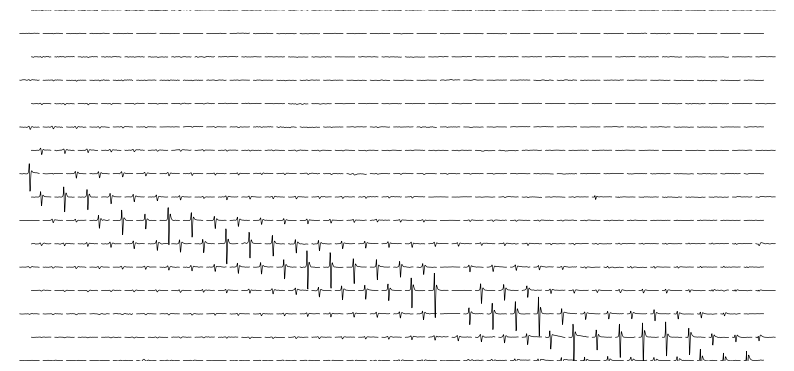

In [7]:
import plot_ei_waveforms
import importlib
importlib.reload(plot_ei_waveforms)
import matplotlib.pyplot as plt
import h5py
import numpy as np

h5_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'

with h5py.File(h5_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]


ei = clusters[0]['ei']

plt.figure(figsize=(10,10))
    
plot_ei_waveforms.plot_ei_waveforms(ei, ei_positions, scale=70.0, box_height=1.0, box_width=50.0, color='black')
plt.show()


### Plot EIs from EI pursuit results

In [8]:
np.set_printoptions(threshold=np.inf, linewidth=200)
all_eis = [cl['ei'] for cl in clusters]
sim = compare_eis(all_eis, None)

print("Final EI similarity matrix:", np.round(sim, 3))


Final EI similarity matrix: [[ 1.     0.257  0.128  0.051  0.12   0.081  0.089  0.096  0.029  0.128  0.037  0.129  0.058  0.046  0.06   0.141  0.117]
 [ 0.257  1.     0.576  0.229  0.439  0.263  0.242  0.349  0.074  0.487  0.17   0.232  0.228  0.062  0.144  0.296  0.31 ]
 [ 0.128  0.576  1.     0.241  0.657  0.18   0.187  0.418  0.109  0.465  0.236  0.361  0.28   0.08   0.21   0.377  0.339]
 [ 0.051  0.229  0.241  1.     0.143  0.066 -0.093  0.153  0.228  0.143  0.245  0.087  0.099  0.176  0.131  0.255  0.142]
 [ 0.12   0.439  0.657  0.143  1.     0.12   0.125  0.229  0.065  0.21   0.075  0.304  0.185  0.039  0.116  0.271  0.299]
 [ 0.081  0.263  0.18   0.066  0.12   1.     0.753  0.144  0.211  0.23   0.158  0.043  0.058  0.079  0.054  0.219  0.064]
 [ 0.089  0.242  0.187 -0.093  0.125  0.753  1.     0.141  0.062  0.2    0.167  0.065  0.045  0.029  0.043  0.252  0.164]
 [ 0.096  0.349  0.418  0.153  0.229  0.144  0.141  1.     0.061  0.524  0.031  0.552  0.713  0.08   0.385  0.124  0.2

In [9]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
    z=np.round(sim, 3),
    colorscale='Viridis',
    colorbar=dict(title='Similarity'),
    zmin=0,
    zmax=1,
    hoverongaps=False
))

fig.update_layout(
    title='EI Similarity Matrix (Final Clusters)',
    xaxis_title='Cluster Index',
    yaxis_title='Cluster Index',
    autosize=False,
    width=600,
    height=600
)

fig.show()


/home/alexth/python_code/Axolotl_v2/plot_ei_python.py:60: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



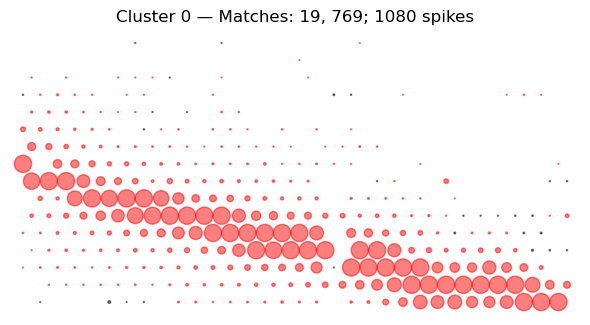

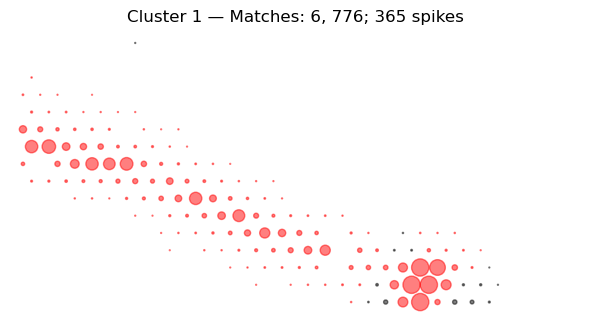

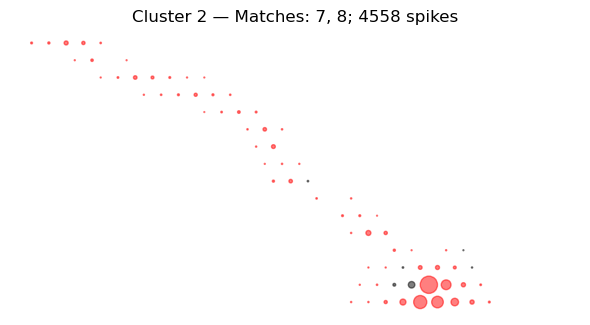

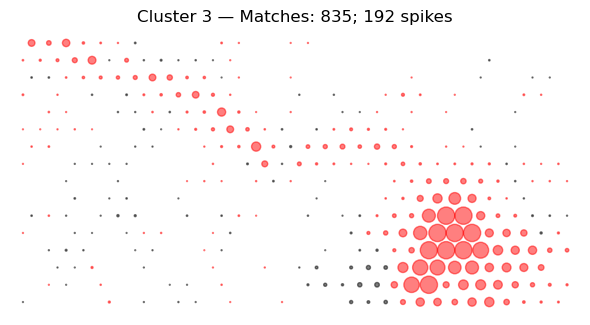

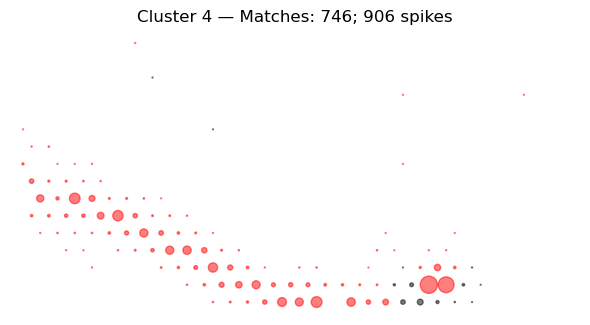

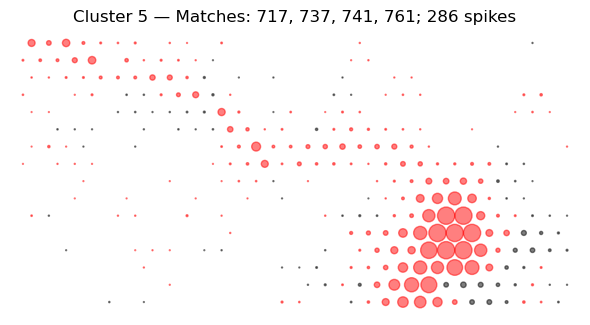

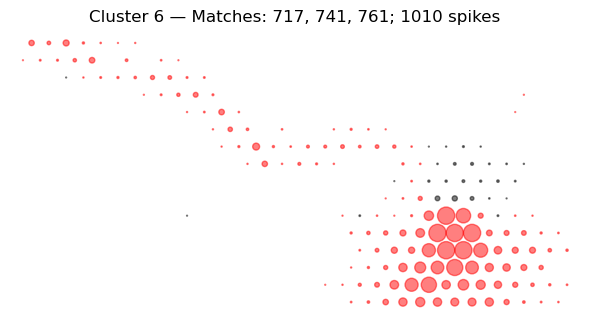

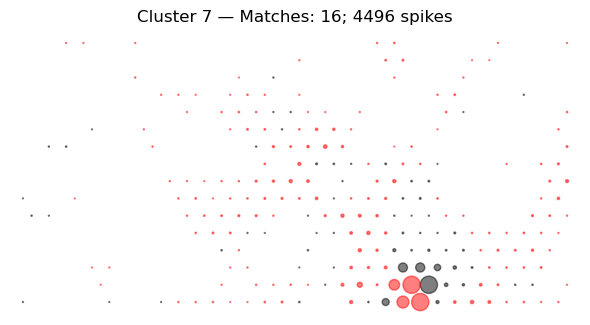

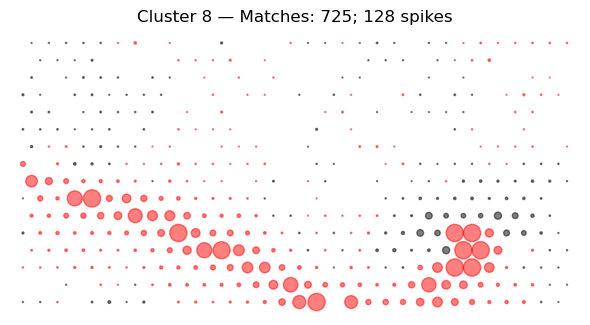

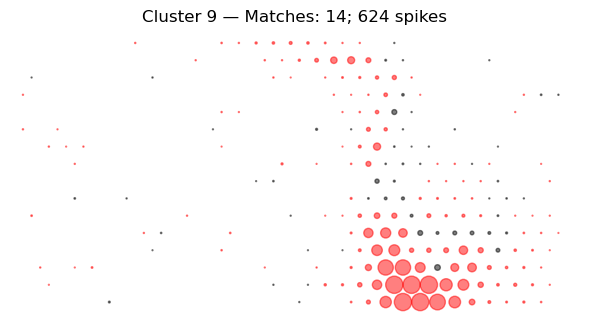

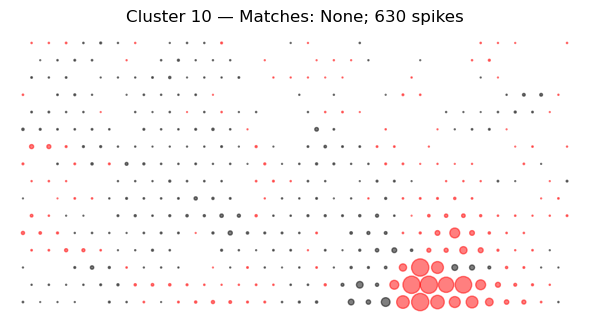

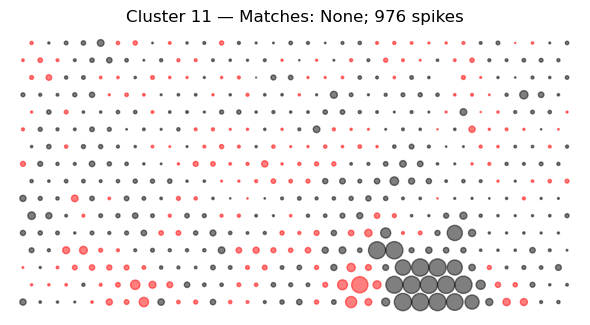

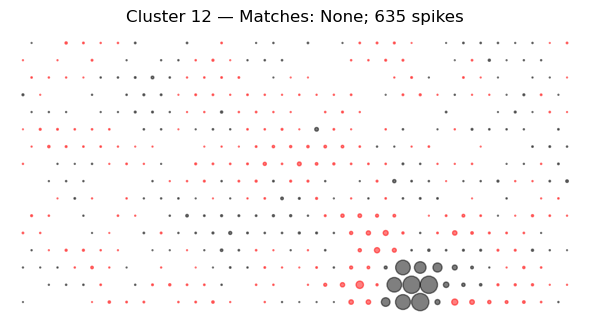

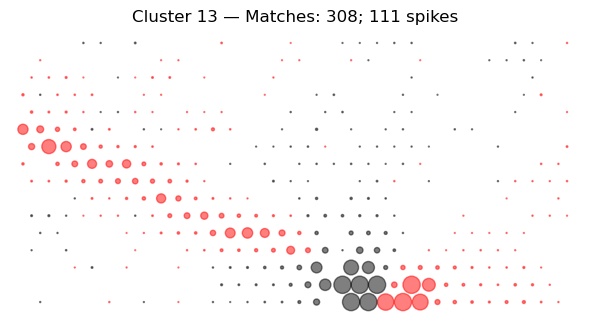

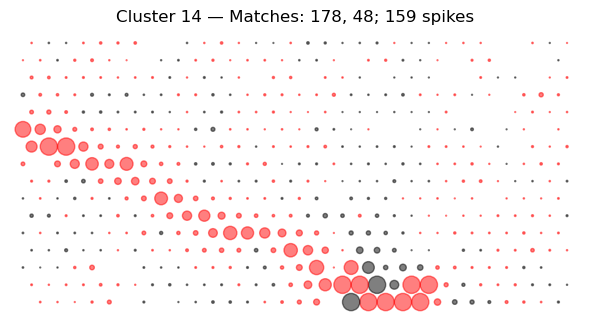

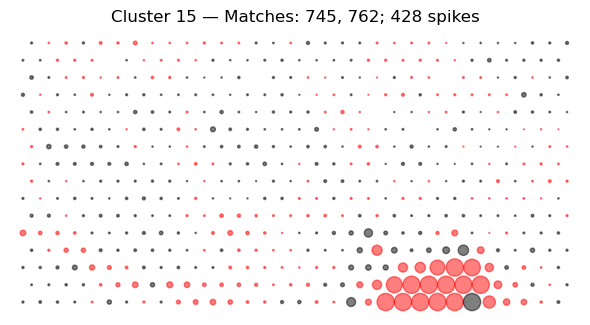

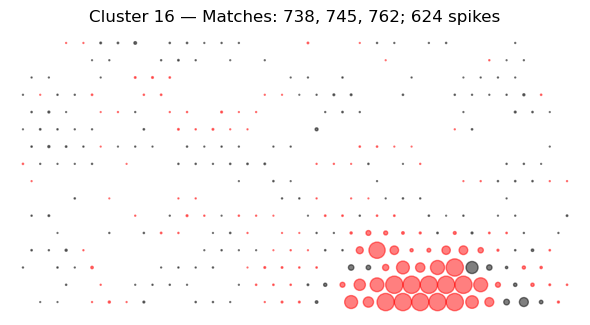

In [10]:
#from plot_ei_python import plot_ei_python
import plot_ei_python
import importlib
importlib.reload(plot_ei_python)
import matplotlib.pyplot as plt
import h5py
import numpy as np

h5_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'

with h5py.File(h5_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

for i, result in enumerate(results):
    ei = clusters[i]['ei']
    matches = result['matches']
    
    plt.figure(figsize=(6, 6))
    
    plot_ei_python.plot_ei_python(ei, ei_positions, label=None, scale=3, cutoff=0.05, neg_color='red', pos_color='black', scale_ref_electrode=None)
    num_spikes = len(clusters[i]['inds'])
    match_str = ', '.join(map(str, matches)) if matches else 'None'
    title_str = f"Cluster {i} — Matches: {match_str}; {num_spikes} spikes"

    plt.title(title_str)
    plt.tight_layout()
    plt.show()


### STA computations

In [22]:
# Get the indices from cluster 3
inds = results[2]['spike_times']           # indices into final_spike_times
spike_samples = final_spike_times[inds]    # actual sample indices
spikes_sec = spike_samples / sampling_rate

print(len(spikes_sec))
print(spikes_sec[:5])

4558
[0.2116  0.26555 0.28985 0.3772  0.4947 ]


### load spike times from original KS

In [21]:
import h5py
import numpy as np

h5_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'

with h5py.File(h5_path, 'r') as f:
    # Sort unit names numerically
    unit_names = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))

    # Load spike times in correct order
    spike_times = [f[f'/spikes/{name}'][:] for name in unit_names]
    
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

spikes_sec = np.asarray(spike_times[3]).flatten()

#spikes_sec = spikes_sec[:68]
print(len(spikes_sec))


1870


In [ ]:
from benchmark_c_rgb_generation import RGBFrameGenerator
from compute_sta_from_spikes import compute_sta_chunked
from scipy.io import loadmat
import numpy as np
import h5py



lut = np.array([
    [255, 255, 255],
    [255, 255,   0],
    [255,   0, 255],
    [255,   0,   0],
    [  0, 255, 255],
    [  0, 255,   0],
    [  0,   0, 255],
    [  0,   0,   0]
], dtype=np.uint8).flatten()

mat = loadmat('/Volumes/Lab/Users/alexth/axolotl/trigger_in_samples_201703151.mat')
triggers_sec = mat['triggers'].flatten()

generator = RGBFrameGenerator('/Volumes/Lab/Users/alexth/axolotl/sta/libdraw_rgb.so')
generator.configure(width=20, height=40, lut=lut, noise_type=1, n_bits=3)
print(len(spikes_sec))

sta = compute_sta_chunked(
    spikes_sec=spikes_sec,                 # your spike times (in samples)
    triggers_sec=triggers_sec,
    generator=generator,
    seed=11111,
    depth=20,
    offset=0,
    chunk_size=1000,
    refresh=2
)


### Plot STA

0.3194383382797241


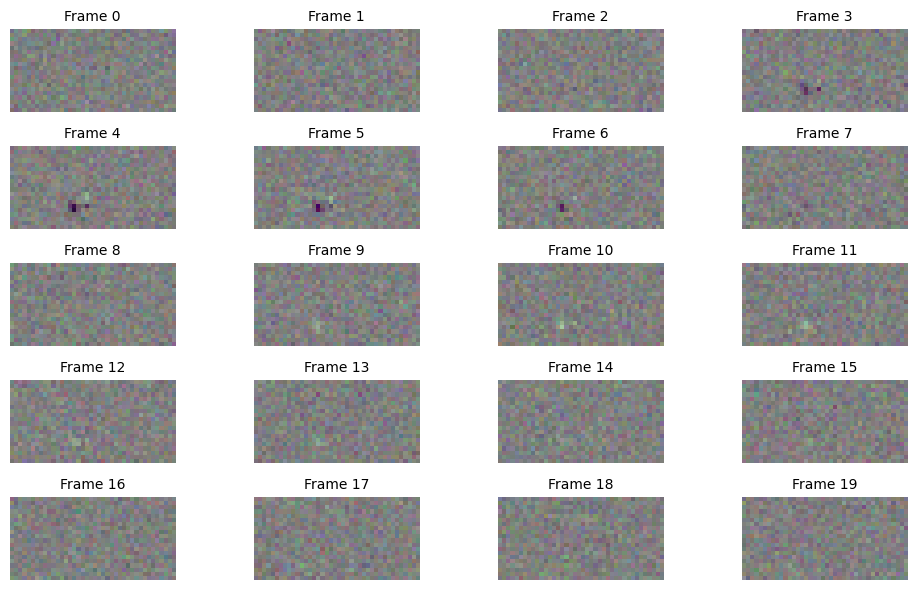

In [24]:
import matplotlib.pyplot as plt
import numpy as np


depth = sta.shape[3]
n_rows, n_cols = 5, 4
vmax = np.max(np.abs(sta)) * 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))
axes = axes.flatten()

print(vmax)

for i in range(n_rows * n_cols):
    ax = axes[i]
    ax.axis('off')
    if i >= depth:
        continue
    rgb = sta[:, :, :, i]
    norm_rgb = (rgb) / (vmax)+0.5
    norm_rgb = np.clip(norm_rgb, 0, 1)
    ax.imshow(norm_rgb.transpose(1, 0, 2), origin='upper')
    ax.set_title(f'Frame {i}', fontsize=10)

plt.tight_layout()
plt.show()


### Below are cells that will run template scoring step by step for a single KS unit

In [ ]:
import matplotlib.pyplot as plt

# Select a unit
unit_idx = 59  # match to your MATLAB cellID
sampling_rate = 20000  # Hz

# Get spike times for the selected unit (in samples)
unit_spike_times_sec = spike_times[unit_idx]
unit_spike_times_sec = np.array(unit_spike_times_sec).flatten()  # flatten cell array structure

unit_spike_times_samples = np.round(unit_spike_times_sec * sampling_rate).astype(int)

# Load snippets around each spike time
from extract_data_snippets import extract_snippets

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
snips = extract_snippets(dat_path, unit_spike_times_samples, window=(-20, 60))  # [512 x 81 x N]

# Compute mean EI
ei_template = np.mean(snips, axis=2)

# Remove baseline (mean of first 5 samples)
ei_template -= np.mean(ei_template[:, :5], axis=1, keepdims=True)

# Compute peak-to-peak amplitude across time
ei_peak2peak = ei_template.max(axis=1) - ei_template.min(axis=1)

# Select channels based on amplitude threshold
amplitude_threshold = 15  # same as MATLAB
selected_by_ei = np.where(ei_peak2peak > amplitude_threshold)[0]  # 0-based, for indexing
selected_channels_plot = selected_by_ei + 1  # 1-based, for matching MATLAB electrode map



In [ ]:

# Extract waveform subset
ei_waveforms = ei_template[selected_by_ei, :]  # [channels x 81]

# Remove baseline from first 5 timepoints
ei_waveforms -= np.mean(ei_waveforms[:, :5], axis=1, keepdims=True)

# Mask: where absolute value > 10% of max for that channel
peak = np.max(np.abs(ei_waveforms), axis=1, keepdims=True)
ei_masks = np.abs(ei_waveforms) > (0.1 * peak)

# Norms of masked waveforms (per channel)
ei_norms = np.linalg.norm(ei_waveforms * ei_masks, axis=1)  # [channels]

#plt.plot(ei_waveforms[0, :])  # Should now match ei_template[33, :]



In [ ]:
from multiprocessing import Process
from run_scoring_block import run_scoring_block
import multiprocessing as mp

mp.set_start_method('spawn', force=True)

total_samples = 36_000_000
n_gpus = 4
chunk = total_samples // n_gpus
selected_channels = selected_by_ei  # from earlier
save_prefix = '/Volumes/Lab/Users/alexth/axolotl/201703151_res'
procs = []
overlap = 80
procs = []


for i in range(n_gpus):

    if i == 0:
        start = 0
    else:
        start = i * chunk

    if i < n_gpus - 1:
        end = (i + 1) * chunk + overlap  # 9_000_000 + 80, etc.
    else:
        end = total_samples  # no extension for last GPU

    n = end - start


    p = Process(
        target=run_scoring_block,
        args=(i, start, n, save_prefix, dat_path,
              ei_template[selected_channels, :],
              ei_masks,
              ei_norms,
              selected_channels,
              'int16',
              None,
              0)
    )
    p.start()
    procs.append(p)


for p in procs:
    p.join()


[GPU 2] Final score array length: 9000000
[GPU 0] Final score array length: 9000000
[GPU 1] Final score array length: 9000000
[GPU 3] Final score array length: 8999920


In [ ]:
import numpy as np

save_prefix = '/Volumes/Lab/Users/alexth/axolotl/201703151_res'

all_mean = []
all_max = []
all_valid = []

for i in range(4):
    path = f"{save_prefix}_gpu{i}.npy"
    data = np.load(path, allow_pickle=True).item()
    all_mean.append(data['mean'])
    all_max.append(data['max'])
    all_valid.append(data['valid'])

# Concatenate across GPUs
mean_score = np.concatenate(all_mean)
max_score = np.concatenate(all_max)
valid_score = np.concatenate(all_valid)

#print("Length:", len(mean_score))



In [ ]:
from scipy.signal import find_peaks

# 1. Compute per-channel template energy
masked_template = ei_template[selected_by_ei, :] * ei_masks
dot_scores = np.sum(masked_template ** 2, axis=1)

# 2. Compute threshold
score_threshold = max(np.mean(dot_scores) / 2, 10000)

# 3. Find local maxima
peaks, _ = find_peaks(mean_score)

# 4. Filter based on threshold and valid_score
valid_inds = peaks[
    (mean_score[peaks] > score_threshold) &
    (valid_score[peaks] > 3)
]

# 5. Adjust for center offset (aligned with snippet start at t - 20)
final_spike_times = valid_inds + 19


In [ ]:
from scipy.signal import argrelextrema

# Local max (>= neighbors), skipping edges
strict_peaks = argrelextrema(mean_score, np.greater_equal, order=1)[0]

# Manually include plateaus
flat_peaks = np.where(
    (np.r_[False, np.diff(mean_score) == 0] &
     np.r_[np.diff(mean_score) == 0, False])
)[0]

# Combine and deduplicate
all_peaks = np.unique(np.concatenate([strict_peaks, flat_peaks]))

# Filter
valid_inds = all_peaks[
    (mean_score[all_peaks] > score_threshold) &
    (valid_score[all_peaks] > 3)
]
final_spike_times = valid_inds + 19

final_spike_times = np.array(final_spike_times, dtype=np.int64)

#print("Total peaks:", len(all_peaks))
#print("Above threshold:", np.sum(mean_score[all_peaks] > score_threshold))
#print("Valid channel count > 3:", np.sum(valid_score[all_peaks] > 3))
#print("Final spike count:", len(final_spike_times))


In [ ]:
from extract_data_snippets import extract_snippets

# Extract centered snippets around detected spike times
snips = extract_snippets(
    dat_path=dat_path,
    spike_times=final_spike_times,
    window=(-20, 60),         # same as MATLAB default
    n_channels=512,
    dtype='int16'
)  # → shape: [512 x 81 x N_spikes]

#print(f"Snippets shape: {snips.shape}")


In [ ]:
from refine_cluster import refine_cluster

inds = refine_cluster(snips, ei_template, selected_by_ei, k=8)


running
running
running


In [ ]:
import torch
import numpy as np

inds_tensor = torch.tensor(inds)

snips_torch = torch.from_numpy(snips)  # [C x T x N]

if len(inds_tensor) == 0:
    ei = torch.zeros_like(torch.from_numpy(ei_template))
else:
    snips_i = snips_torch[:, :, inds_tensor]
    ei = torch.mean(snips_i, dim=2)
    ei = ei - ei[:, :5].mean(dim=1, keepdim=True)

ei_numpy = ei.numpy()  # If you need to use it elsewhere
